In [ ]:
!pip install learn2learn

     |████████████████████████████████| 1.4MB 9.2MB/s 
     |████████████████████████████████| 2.9MB 36.9MB/s 
     |████████████████████████████████| 174kB 52.0MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 1.4MB 47.3MB/s 
     |████████████████████████████████| 112kB 54.7MB/s 
     |████████████████████████████████| 3.2MB 53.4MB/s 
  Created wheel for learn2learn: filename=learn2learn-0.1.5-cp37-cp37m-linux_x86_64.whl size=918070 sha256=afe7ff817df31d84f10b6541232590a18a39a864889b55a0bc385e95d957a30b
  Stored in directory: /root/.cache/pip/wheels/5a/44/11/9d755af86d74f353dc7e56d5e75668e4ae7f5bf8c7d74f1f7e
  Created wheel for gsutil: filename=gsutil-4.61-cp37-none-any.whl size=3709861 sha256=7ea48f5854bf3c252316709e1dbb5f8704c099411a5879b37412589bc996de20
  Stored in directory: /root/.cache/pip/wheels/21/c8/4c/b30f998197ac91

In [ ]:
!wget https://raw.githubusercontent.com/davda54/sam/main/sam.py

--2021-05-02 20:03:53--  https://raw.githubusercontent.com/davda54/sam/main/sam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2126 (2.1K) [text/plain]
Saving to: ‘sam.py’

sam.py              100%[===================>]   2.08K  --.-KB/s    in 0s      

2021-05-02 20:03:54 (31.5 MB/s) - ‘sam.py’ saved [2126/2126]



## Import Libraries

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.autograd import Variable
from torch.utils.data import Dataset

import numpy as np
from numpy.random import RandomState

import matplotlib.pyplot as plt

from copy import deepcopy

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import learn2learn as l2l
from learn2learn.data.transforms import NWays, KShots, LoadData, RemapLabels

from sam import SAM

from PIL import Image

import time as timer

ModuleNotFoundError: ignored

## Global Setup

In [ ]:
# reproducibility
torch.manual_seed(0)

# number of (training, validation) subsets
n_subsets = 3

Setting up the device 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## Setup data and loaders

In [ ]:
# normalize the data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

transform_train = transforms.Compose([transforms.ToTensor(), normalize]) 
transform_val = transforms.Compose([transforms.ToTensor(), normalize])

# download datasets
cifar_data_train = datasets.CIFAR10(root='datasets', train=True, transform=transform_train, download=True)
cifar_data_val = datasets.CIFAR10(root='datasets', train=True, transform=transform_train, download=True)
cifar_data_tst =datasets.CIFAR10(root='datasets', train=False, transform=transform_train, download=True)

# create subsets and associated dataloaders
subsets = [None] * n_subsets
dataloaders = [None] * n_subsets
test_loader =[None]*n_subsets

train_bs = 20 
val_bs= 1

for i in range(n_subsets):
  prng = RandomState(i)
  random_permute = prng.permutation(np.arange(0, 5000))
  indx_train = np.concatenate([np.where(np.array(cifar_data_train.targets) == classe)[0][random_permute[0:10]] for classe in range(0, 10)])
  indx_val = np.concatenate([np.where(np.array(cifar_data_train.targets) == classe)[0][random_permute[10:210]] for classe in range(0, 10)])
  random_permute = prng.permutation(np.arange(0, 900))
  indx_tst = np.concatenate([np.where(np.array(cifar_data_tst.targets) == classe)[0][random_permute[0:200]] for classe in range(0, 10)])
  
  train_subset = Subset(cifar_data_train, indx_train)
  val_subset =  Subset(cifar_data_val, indx_val)
  tst_subset = Subset(cifar_data_tst, indx_tst)

  subsets[i] = (train_subset, val_subset)
  dataloaders[i] = (torch.utils.data.DataLoader(train_subset, batch_size=train_bs, shuffle=True),
                    torch.utils.data.DataLoader(val_subset, batch_size=val_bs, shuffle=False))
  test_loader[i] = torch.utils.data.DataLoader(tst_subset,batch_size=val_bs,shuffle=False)

In [ ]:
class augmentation(object): # A class that does augmentations (horizontal an vertical flipping, random prespective, and rotation) on the passed images
  def __init__(self):
    
    self.horizontal_flip = torchvision.transforms.RandomHorizontalFlip(p=1)
    self.vertical_flip =torchvision.transforms.RandomVerticalFlip(p=1)
    self.distortion = torchvision.transforms.RandomPerspective(distortion_scale=0.25, p=1)
    
    
  def forward(self,img,label):
    """ 
    Args:
        img: Pass images to be augmented using classical augmentations such as horizontal an vertical flipping, random prespective, and rotation
        label: Pass the labels to be increased according to the number of augmentations
    Returns: a classically augmented data set with the corresponding labels
        - augmentations: A torch tensor 
    Shape: 
        - img: any image shape
        - augmentations is 5x the batch size of the input img similarly for the targets
    """
    n, c, h, w = img.shape
    augmentations = torch.empty((n*5, c,h,w),dtype=torch.float32)
    targets = torch.empty(n*5,dtype=torch.long)
    for t in range(0,n*5,n):
      targets[t:t+n] = label
    
    augmentations [0:n] = self.horizontal_flip(img)
    augmentations [n:2*n] = self.vertical_flip(img)
    augmentations [2*n:3*n] = self.distortion(img)
    augmentations [3*n:4*n] = torchvision.transforms.functional.rotate(img, 10)
    augmentations [4*n:5*n] = img 
    return augmentations, targets


In [ ]:
def image_normalizer(image):
    r"""Normalizes the input to scale [0 1].

    Args:
        image (np.ndarray or torch.Tensor): image to be rescaled

    Returns:
        (np.ndarray or torch.Tensor): rescaled image

    Shape:
        - image: (*) Any shape
        - output: Same shape as input
    """
    return (image - image.min()) / (image.max() - image.min())

#Training and Testing Loop

In [ ]:
def mixup_data(x, y, device):                                                   # Implements Mixup augmentation from https://arxiv.org/pdf/1710.09412.pdf
    '''Returns mixed inputs, pairs of targets, and lambda'''
  
    lam = np.random.beta(1.0, 1.0)
    

    batch_size = x.size()[0]
   
    index = torch.randperm(batch_size).to(device)
    

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):                            # Training loss criteria for Mixup 
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [ ]:
def ricap(images, targets,beta,device):                                         # Implements RICAP augmentation technique from https://arxiv.org/pdf/1811.09030.pdf


  # size of image
  I_x, I_y = images.size()[2:]

  # generate boundary position (w, h)
  w = int(np.round(I_x * np.random.beta(beta, beta)))
  h = int(np.round(I_y * np.random.beta(beta, beta)))
  w_ = [w, I_x - w, w, I_x - w]
  h_ = [h, h, I_y - h, I_y - h]

  # select four images
  cropped_images = {}
  c_ = {}
  W_ = {}
  for k in range(4):
      index = torch.randperm(images.size(0)).to(device)
      x_k = np.random.randint(0, I_x - w_[k] + 1)
      y_k = np.random.randint(0, I_y - h_[k] + 1)
      cropped_images[k] = images[index][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
      c_[k] = targets[index]
      W_[k] = (w_[k] * h_[k]) / (I_x * I_y)

  # patch cropped images
  patched_images = torch.cat(
      (torch.cat((cropped_images[0], cropped_images[1]), 2),
        torch.cat((cropped_images[2], cropped_images[3]), 2)),
      3)

  targets = (c_, W_)
  return patched_images, targets

def ricap_criterion(outputs, targets):                                          # Training loss criteria for RICAP
  c_, W_ = targets
  loss = sum([W_[k] * F.cross_entropy(outputs, Variable(c_[k])) for k in range(4)])
  return loss

In [ ]:
def train(model, device, train_loader, optimizer, epoch,mode,ricap_beta, SAM,display=True):
  """ Args:
        -model: the model to be trained
        -device: CPU or GPU device
        -train_loader: loader for the training data
        -optimizer: torch.optim.Adam, torch.optim.SGD, etc...
        -epoch: current epoch number
        -ricap_beta: a hyperparameter used with RICAP augmentations 
        -SAM: True -- if SAM is to be used for optimization
      Returns:
        -loss and accuracy at each epoch evaluated based on the train_loader
  """
  augment = augmentation()   
  correct =0
  model.train()                                                                 # set the model to training mode for techniques such as batchnorm
  criterion = nn.CrossEntropyLoss()
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)                         # Moving data to the chosen device (no augmentations)
      original_data, original_targets = deepcopy(data).to(device),deepcopy(target).to(device) # Copying the data and targets for training evaluation (loss and acc) at the end of each batch training
      data, target = augment.forward(data,target) 
      data, target = data.to(device),target.to(device)        
      if mode =='mixup':                                                        # If the chosen augmentation mode is "Mixup"
        data, targets_a, targets_b, lam = mixup_data(data, target,device)
        data, targets_a, targets_b = map(Variable, (data,targets_a, targets_b))
      elif mode == 'ricap':                                                     # If the chosen augmentation mode is "RICAP                                                     
        data, target = ricap(data,target,ricap_beta,device)                     # Beta is a hyperparameter and is chosen to be 0.05 in our experiments
      
      optimizer.zero_grad()
      
      
      def closure():                                                            #Needed by Sharpness Aware Minimization (SAM) optimizer to reevaluate the model                            
        if mode =='mixup':                                                    
          loss = mixup_criterion(criterion, model(data), targets_a, targets_b, lam)
        elif mode == 'ricap':
          loss = ricap_criterion(model(data),target)
        else:                                                
          loss = F.cross_entropy(model(data),target)
        
        loss.backward()
        return loss
        
      
      if mode == 'mixup':
        loss = mixup_criterion(criterion, model(data), targets_a, targets_b, lam)
      elif mode == 'ricap':
        loss = ricap_criterion(model(data),target)
      else:                                                  
        loss = F.cross_entropy(model(data),target)
      
      loss.backward()
      if SAM == True :
        optimizer.step(closure)
      else: 
        optimizer.step()

      pred = model(original_data).max(1, keepdim=True)[1]                       # get the index of the max log-probability
      correct += pred.eq(original_targets.view_as(pred)).sum().item()
      
  if display:
        print(f"Train Epoch: {epoch} [{epoch}/100 ({epoch}%)]     Loss: {loss:.5f}")
  return loss , correct/len(train_loader.dataset)                               # returns loss and accuracy each epoch

def test(model, device, test_loader):
  """Args:
      - model: the model to be trained
      - device: CPU or GPU device
      - test_loader: test dataloader
    Returns: Accuracy evaluated using the test_loader
  """
  model.eval()
  test_loss = 0
  correct = 0
  augment = augmentation()                                                    # Instantiate an augmentations class to do Test Time Augmentations (TTA)
  with torch.no_grad():
      for idx , (data, target) in enumerate(test_loader):                     # The test loader loads one image at a time (batch_size =1)
        data, _ = augment.forward(data,target)                                # Get augmentations of the test image 
        data, target = data.to(device), target.to(device)                     
        
        output = torch.empty((5,10),dtype=torch.float32)                      # The output will be of shape 5 augmentations x 10 class predictions
        output = output.to(device)
        for a in range(5):  
          X = data[a].unsqueeze(0)                                      
          output[a,:]= model(X)                                               # Getting the prediction for each augmentation and the original test image
        out = output.mean(axis=0).unsqueeze(0)                                # Averaging the predictions (TTA)
        test_loss += F.cross_entropy(out,target)                  
        pred = out.max(1, keepdim=True)[1]                                    # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
          
  
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss/len(test_loader.dataset), correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return 100. * correct / len(test_loader.dataset)

In [ ]:
def ensemble_test(model_dict, device, test_loader):                            
    
    """
    Implements testing over multiple models (ensembles them) to make predictions
    Args:
      - model_dict: dictionary that has the models that will be used perform ensembling 
      - device: CPU or GPU device
      - test_loader: test dataloader
    Returns: Accuracy evaluated using the test_loader
  """
    predictions = []
    test_loss = 0
    correct = 0
    augment = augmentation()                                                    # Instantiating an augmentation model 
    with torch.no_grad():
        for idx , (data, target) in enumerate(test_loader):                     # The test loader batch size is 1 
          data, _ = augment.forward(data,target)                                # Get augmentations 4 + original so data is 5x32x32
          data, target = data.to(device), target.to(device)
          
          output = torch.empty((5,10),dtype=torch.float32)                      # A tensor to store the predictions over augmentation: 5 augmentations x 10 class predictions
          output = output.to(device)
          out= torch.empty((len(model_dict),10),dtype=torch.float32)            # A tensor to store the predictions of different models 
          out = out.to(device)
          
          for id, key in enumerate(model_dict):
            model = model_dict[key]                                             # Select a model 
            model.eval()                                                        # Setting the model to evaluation mode for techniques such as batchnorm
            output  = model(data)                                               # Performing a forward pass on the data + augmentations
            out[id,:]= output.mean(axis=0).unsqueeze(0)                         # Average the 5 outputs (image + its augmentations) of a certain model and store it in "out" 
          test_loss += F.cross_entropy(out.mean(axis=0).unsqueeze(0),target)    # Obtaining the average of "out" == ensembling over different models
          pred = out.mean(axis=0).unsqueeze(0).max(1, keepdim=True)[1]          # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          
      
     
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss/len(test_loader.dataset), correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

# Models

Use this to calculate the size of the activation maps

In [ ]:

h_in= 32
padd =0
dilation=1
kernel = 3
stride = 2
((h_in+2*padd-dilation*(kernel-1)-1)/stride) +1

15.5

In [ ]:
class Testbed_Net(torch.nn.Module):
    def __init__(self):
        super(Testbed_Net, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3), 
                      nn.ReLU(inplace=True)]
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), 
                      nn.ReLU(inplace=True)]
        self.fc = nn.Linear(32*5*5, 10)
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)
        x = x.view(-1, 32*5*5)
        x = self.fc(x)
        return x

In [ ]:
class four_layer_CNN(torch.nn.Module):
    def __init__(self):
        super(four_layer_CNN, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) ,  # 32-3/1 +1 30x30 (Input height - kernel height) / stride height + 1, default stride is 1,  H_out = 30 W_out =30
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.MaxPool2d(kernel_size=3,stride=1),
                      nn.Dropout2d(p=0.25, inplace=True)] # 30-3 /1 +1 28x28
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2), # 28-3/2 +1 13x13
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.Dropout2d(p=0.25, inplace=True)]
                      
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3),# 11-3/1 +1  9x9
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(32),
                      nn.Dropout2d(p=0.25, inplace=True)]
                      
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2), # 7-3 /2 +1 3x3 
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(32),
                      nn.Dropout2d(p=0.25, inplace=True),
                      nn.AvgPool2d(kernel_size=3,stride=1)] #3 -
        self.fc = nn.Linear(32*3*3, 10) # 32 activation maps each is 3x3
        
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)  # forward passing through all the layers 
        x = x.view(-1, 32*3*3)   # flattening for the final layer 
        x = self.fc(x)           # fully connected layer 
        
        return x

In [ ]:
class four_layer_dilated_CNN(torch.nn.Module):
    def __init__(self):
        super(four_layer_dilated_CNN, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , #30x30
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.MaxPool2d(kernel_size=3,stride=1), # 28x28
                      nn.Dropout2d(p=0.25, inplace=True)] 
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2,dilation=2,padding=2), # 14x14
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.Dropout2d(p=0.25, inplace=True)]
                       
        self.layers+=[nn.Conv2d(16, 32,  kernel_size=3,dilation=2,padding=2),# 14x14 
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(32),
                      nn.Dropout2d(p=0.25, inplace=True)]
                     
        self.layers+=[nn.Conv2d(32, 32,  kernel_size=3, stride=2,padding=2), # 8x8 
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(32),
                      nn.Dropout2d(p=0.25, inplace=True),
                      nn.AvgPool2d(kernel_size=3,stride=1)] # 6x6
        self.fc = nn.Linear(32*6*6, 10) # 32 activation maps each is 6x6
        
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)  # forward passing through all the layers 
        x = x.view(-1, 32*6*6)   # flattening for the final layer 
        x = self.fc(x) # fully connected layer 
        
        return x

In [ ]:
class two_layer_dilated_CNN(torch.nn.Module):
    def __init__(self):
        super(two_layer_dilated_CNN, self).__init__()
        self.layers = nn.ModuleList()
        
        self.layers+=[nn.Conv2d(3, 16,  kernel_size=3) , #30x30
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.MaxPool2d(kernel_size=3,stride=1), # 28x28
                      nn.Dropout2d(p=0.25, inplace=True)] 
        self.layers+=[nn.Conv2d(16, 16,  kernel_size=3, stride=2,dilation=2,padding=2), # 14x14
                      nn.ReLU(inplace=True),
                      nn.BatchNorm2d(16),
                      nn.Dropout2d(p=0.25, inplace=True),
                      nn.AvgPool2d(kernel_size=3,stride=1)] 
        
        
        self.fc = nn.Linear(16*12*12, 10) # 16 activation maps each is 12x12
        
        
    def forward(self, x):
        for i in range(len(self.layers)):
          x = self.layers[i](x)  # forward passing through all the layers 
        x = x.view(-1, 16*12*12)   # flattening for the final layer 
        x = self.fc(x) # fully connected layer 
        
        return x

In [ ]:
class Convnet(nn.Module):

    def __init__(self, x_dim=3, hid_dim=64, z_dim=64):
        super().__init__()
        self.encoder = l2l.vision.models.ConvBase(output_size=z_dim,
                                                  hidden=hid_dim,
                                                  channels=x_dim,
                                                  max_pool=True)
        self.fc = nn.Linear(2*2*64,10)

    def forward(self, x):
        x = self.encoder(x)
        x= x.view(-1,2*2*64)
        return self.fc(x)

In [ ]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()
    self.fc = nn.Linear(256,10)
  def forward(self, x):
    x = x.view(-1, 256)   # flattening for the final layer 
        
    return self.fc(x)


x_dim=3
hid_dim=64
z_dim=64

def conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, 3, padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      nn.MaxPool2d(2)
      )
  
encoder = nn.Sequential(conv_block(x_dim, hid_dim),
                        conv_block(hid_dim, hid_dim),
                        conv_block(hid_dim, hid_dim),
                        conv_block(hid_dim, z_dim),
                        Flatten()
                        )

# Testbed benchmark for train and test runtimes 

In [ ]:
accs_tb=[]

for seed in [1,2,3]:
  
  model = Testbed_Net()
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), 
                              lr=0.01, momentum=0.9,
                              weight_decay=0.0005)
  start = timer.time()
  for epoch in range(300):
    train(model, device, dataloaders[seed][0], optimizer, epoch, mode='None',ricap_beta=0,SAM=False,display=epoch%5==0)
  end = timer.time() - start 
  runtime_tb_training= end
  print(f"Training was done in {end:.2f} seconds!")
  start = timer.time()
  accs_tb.append(test(model, device, dataloaders[seed][1]))
  end = timer.time() - start 
  runtime_tb_testing = end 
  print(f"Testing on test set I was done in {end:.2f} seconds!")

accs_tb = np.array(accs_tb)
print('Acc over 2 instances from test set I: %.2f +- %.2f'%(accs_tb.mean(),accs_tb.std()))


Train Epoch: 0 [0/100 (0%)]     Loss: 2.30066
Train Epoch: 5 [5/100 (5%)]     Loss: 2.29230
Train Epoch: 10 [10/100 (10%)]     Loss: 2.18309
Train Epoch: 15 [15/100 (15%)]     Loss: 1.96941
Train Epoch: 20 [20/100 (20%)]     Loss: 1.64755
Train Epoch: 25 [25/100 (25%)]     Loss: 1.50560
Train Epoch: 30 [30/100 (30%)]     Loss: 0.69462
Train Epoch: 35 [35/100 (35%)]     Loss: 1.07198
Train Epoch: 40 [40/100 (40%)]     Loss: 0.38905
Train Epoch: 45 [45/100 (45%)]     Loss: 0.73091
Train Epoch: 50 [50/100 (50%)]     Loss: 0.17296
Train Epoch: 55 [55/100 (55%)]     Loss: 0.04220
Train Epoch: 60 [60/100 (60%)]     Loss: 0.01671
Train Epoch: 65 [65/100 (65%)]     Loss: 0.00601
Train Epoch: 70 [70/100 (70%)]     Loss: 0.06613
Train Epoch: 75 [75/100 (75%)]     Loss: 0.00495
Train Epoch: 80 [80/100 (80%)]     Loss: 0.00181
Train Epoch: 85 [85/100 (85%)]     Loss: 0.00154
Train Epoch: 90 [90/100 (90%)]     Loss: 0.00180
Train Epoch: 95 [95/100 (95%)]     Loss: 0.00865
Train Epoch: 100 [100/100 

#Evaluate Models

In [ ]:
# Use a dictionary of models to implement an ensemble of different models
model_dict= {
             "4-layer CNN": four_layer_CNN(),
             "4-layer Dilated CNN":four_layer_dilated_CNN(),
             "2-layer Dilated CNN":two_layer_dilated_CNN(),
             #"ConvNet": Convnet(), # uses learn2learn library
             "ConvNet":encoder , # an equivalent model to ConvNet that doesn't use learn2learn library(used in the solution submitted to Codalab)
             }

In [ ]:
print("ConvNet")
model_dict["ConvNet"]

ConvNet


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05

#Training of our second best model (ensemble of models)

In [ ]:
accs = []
final_accs=[]
train_losses = {new_list:[] for new_list in range(len(model_dict))}
train_accuracies ={new_list:[] for new_list in range(len(model_dict))}

runtime_train_subsets=[]
runtime_test =  []


n_epochs =300
for subset in range(n_subsets):
  trained_models= dict()
  ctr = 0
  runtime_train = {new_list:[] for new_list in range(len(model_dict))}
  for m in model_dict:
    
    model =  deepcopy(model_dict[m])                                            # getting a model from the model dictionary
    model.to(device)                                                            # Moving the model to device
    
    base_optimizer = optim.Adam                                                 # selecting a base optimizer to be used with SAM
    optimizer = SAM(model.parameters(),base_optimizer,lr=1e-3)                  # Initializing SAM optimizer
    

    print(f"Training {m} in progress...")
    
    start = timer.time()
    for epoch in range(n_epochs):
       if epoch <=2*n_epochs//3 :
         if epoch == 0:
           print("Augmenting using RICAP...")
         loss , accuracy = train(model, device, dataloaders[subset][0],optimizer, epoch, mode = 'ricap',ricap_beta=0.05,SAM= True,display=epoch%5==0)
       else:
         if epoch == (2*n_epochs//3) + 1:
          print("Augmenting using Mixup...")
         loss , accuracy = train(model, device, dataloaders[subset][0],optimizer, epoch, mode='mixup',ricap_beta= 0.05, SAM= True, display=epoch%5==0)
       if epoch% 5 == 0 :
         train_losses[ctr].append(loss)
       
       train_accuracies[ctr].append(accuracy)
    
    
    end = timer.time() - start 
    runtime_train[ctr]=end
    print(f"Successfully trained {m} in {end:.2f} seconds!")
    #print(f"Successfully trained {m}!")
    trained_models[m] = model
    ctr= ctr +1
  print("Testing using test set I ....")
  
  start = timer.time()
  accs.append(ensemble_test(trained_models,device,dataloaders[subset][1]))
  
  end = timer.time() - start 
  
  print(f"Tested using test set I in {end:.2f} seconds")
  print("Testing using test set II ....")
  final_accs.append(ensemble_test(trained_models,device,test_loader[subset]))
  runtime_train_subsets.append(runtime_train)
  runtime_test.append(end)
   
accs = np.array(accs)
final_accs = np.array(final_accs)
print(f"Acc over {subset+1} instances of test set I  is: {accs.mean():.2f} +- {accs.std():.2f}")
print(f"Acc over {subset+1} instances of test set II is: {final_accs.mean():.2f} +- {final_accs.std():.2f}")

Training 4-layer CNN in progress...
Augmenting using RICAP...
Train Epoch: 0 [0/100 (0%)]     Loss: 2.30719
Train Epoch: 5 [5/100 (5%)]     Loss: 2.00097
Train Epoch: 10 [10/100 (10%)]     Loss: 2.18912
Train Epoch: 15 [15/100 (15%)]     Loss: 2.20667
Train Epoch: 20 [20/100 (20%)]     Loss: 1.76837
Train Epoch: 25 [25/100 (25%)]     Loss: 1.68090
Train Epoch: 30 [30/100 (30%)]     Loss: 1.55795
Train Epoch: 35 [35/100 (35%)]     Loss: 2.17789
Train Epoch: 40 [40/100 (40%)]     Loss: 2.06631
Train Epoch: 45 [45/100 (45%)]     Loss: 1.33640
Train Epoch: 50 [50/100 (50%)]     Loss: 1.24020
Train Epoch: 55 [55/100 (55%)]     Loss: 1.46370
Train Epoch: 60 [60/100 (60%)]     Loss: 1.55463
Train Epoch: 65 [65/100 (65%)]     Loss: 1.24347
Train Epoch: 70 [70/100 (70%)]     Loss: 1.04620
Train Epoch: 75 [75/100 (75%)]     Loss: 0.86410
Train Epoch: 80 [80/100 (80%)]     Loss: 1.06992
Train Epoch: 85 [85/100 (85%)]     Loss: 0.89713
Train Epoch: 90 [90/100 (90%)]     Loss: 0.96750
Train Epoch: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes curren

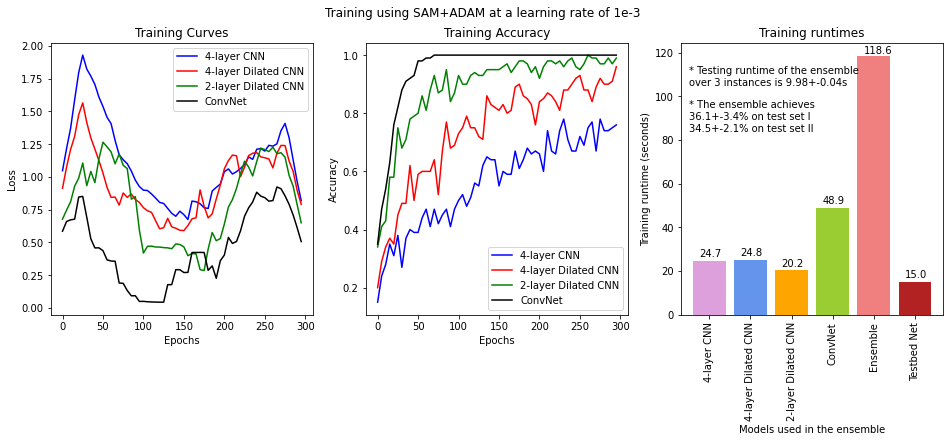

In [ ]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(16,5))
for t in range(4):
  plt.suptitle(r"Training using SAM+ADAM at a learning rate of 1e-3")
  plt.subplot(1,3,1)
  y_hat = smooth(train_losses[t][0:60],10)
  plt.plot(y_hat,color=colors[t])
  #plt.plot(np.array(train_losses[0])[0:60],color= colors[t])
  plt.xticks([0,10,20,30,40,50,60],[0,50,20*5,30*5,40*5,50*5,60*5])
  plt.title("Training Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(model_dict.keys())
  plt.subplot(1,3,2)
  plt.plot(np.array(train_accuracies[t])[0:60],color= colors[t])
  plt.xticks([0,10,20,30,40,50,60],[0,50,20*5,30*5,40*5,50*5,60*5])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(model_dict.keys())
  plt.subplot(1,3,3)
mm= ['4-layer CNN', '4-layer Dilated CNN', '2-layer Dilated CNN', 'ConvNet']
#plt.figure(figsize=(5,5))
plt.bar(model_dict.keys(),runtime_train_subsets[0].values(),color=["plum","cornflowerblue","orange","yellowgreen"])
plt.bar("Ensemble",np.array(list((runtime_train_subsets[0].values()))).sum(),color='lightcoral')
plt.text(4-0.25,np.array(list((runtime_train_subsets[0].values()))).sum()+1, str(np.round(np.array(list((runtime_train_subsets[0].values()))).sum(),decimals=1)))
plt.text(-0.5,105,f"* Testing runtime of the ensemble \nover 3 instances is {np.array(runtime_test).mean():.2f}+-{np.array(runtime_test).std():.2f}s",color='black')
plt.text(-0.5,84,f"* The ensemble achieves \n{accs.mean():.1f}+-{accs.std():.1f}% on test set I \n{final_accs.mean():.1f}+-{final_accs.std():.1f}% on test set II")
plt.bar("Testbed Net",runtime_tb_training,color='firebrick')
plt.text(5-0.25,runtime_tb_training+2,str(np.round(runtime_tb_training,decimals=1)))
plt.xticks(rotation='vertical')
plt.title("Training runtimes")
plt.xlabel("Models used in the ensemble")
plt.ylabel("Training runtime (seconds)")
t=0
for val in runtime_train_subsets[0]:
  plt.text(t-0.25,runtime_train_subsets[0][val]+2,str(np.round(runtime_train_subsets[0][val],decimals=1)))
  t=t+1

# The training our best model (ConvNet)

In [ ]:
model_dict= {
             "ConvNet":encoder 
             }

In [ ]:
accs = []
final_accs=[]
train_losses = {new_list:[] for new_list in range(len(model_dict))}
train_accuracies ={new_list:[] for new_list in range(len(model_dict))}

runtime_train_subsets=[]
runtime_test =  []


n_epochs =300
for subset in range(n_subsets):
  trained_models= dict()
  ctr = 0
  runtime_train = {new_list:[] for new_list in range(len(model_dict))}
  for m in model_dict:
    
    model =  deepcopy(model_dict[m])                                            # getting a model from the model dictionary
    model.to(device)                                                            # Moving the model to device
    
    base_optimizer = optim.Adam                                                 # selecting a base optimizer to be used with SAM
    optimizer = SAM(model.parameters(),base_optimizer,lr=1e-3)                  # Initializing SAM optimizer
    

    print(f"Training {m} in progress...")
    
    start = timer.time()
    for epoch in range(n_epochs):
       if epoch <=2*n_epochs//3 :
         if epoch == 0:
           print("Augmenting using RICAP...")
         loss , accuracy = train(model, device, dataloaders[subset][0],optimizer, epoch, mode = 'ricap',ricap_beta=0.05,SAM= True,display=epoch%5==0)
       else:
         if epoch == (2*n_epochs//3) + 1:
          print("Augmenting using Mixup...")
         loss , accuracy = train(model, device, dataloaders[subset][0],optimizer, epoch, mode='mixup',ricap_beta= 0.05, SAM= True, display=epoch%5==0)
       if epoch% 5 == 0 :
         train_losses[ctr].append(loss)
       
       train_accuracies[ctr].append(accuracy)
    
    
    end = timer.time() - start 
    runtime_train[ctr]=end
    print(f"Successfully trained {m} in {end:.2f} seconds!")
    trained_models[m] = model
    ctr= ctr +1                                                                 # control to cycle between models
  print("Testing using test set I ....")
  
  start = timer.time()
  accs.append(ensemble_test(trained_models,device,dataloaders[subset][1]))
  end = timer.time() - start 
  
  print(f"Tested using test set I in {end:.2f} seconds")
  print("Testing using test set II ....")
  final_accs.append(ensemble_test(trained_models,device,test_loader[subset]))
  runtime_train_subsets.append(runtime_train)
  runtime_test.append(end)
   
accs = np.array(accs)
final_accs = np.array(final_accs)
print(f"Acc over {subset+1} instances of test set I  is: {accs.mean():.2f} +- {accs.std():.2f}")
print(f"Acc over {subset+1} instances of test set II is: {final_accs.mean():.2f} +- {final_accs.std():.2f}")

Training ConvNet in progress...
Augmenting using RICAP...
Train Epoch: 0 [0/100 (0%)]     Loss: 2.22587
Train Epoch: 5 [5/100 (5%)]     Loss: 1.56068
Train Epoch: 10 [10/100 (10%)]     Loss: 0.70855
Train Epoch: 15 [15/100 (15%)]     Loss: 0.31953
Train Epoch: 20 [20/100 (20%)]     Loss: 0.21328
Train Epoch: 25 [25/100 (25%)]     Loss: 1.97745
Train Epoch: 30 [30/100 (30%)]     Loss: 0.08352
Train Epoch: 35 [35/100 (35%)]     Loss: 0.09024
Train Epoch: 40 [40/100 (40%)]     Loss: 0.05475
Train Epoch: 45 [45/100 (45%)]     Loss: 0.06506
Train Epoch: 50 [50/100 (50%)]     Loss: 0.03981
Train Epoch: 55 [55/100 (55%)]     Loss: 0.03573
Train Epoch: 60 [60/100 (60%)]     Loss: 0.04625
Train Epoch: 65 [65/100 (65%)]     Loss: 0.04803
Train Epoch: 70 [70/100 (70%)]     Loss: 0.02641
Train Epoch: 75 [75/100 (75%)]     Loss: 0.08900
Train Epoch: 80 [80/100 (80%)]     Loss: 0.04101
Train Epoch: 85 [85/100 (85%)]     Loss: 0.01178
Train Epoch: 90 [90/100 (90%)]     Loss: 1.64343
Train Epoch: 95 [

### Experiments

This cell is used to run the following experiments:
- ConvNet vs different augmentation methods (RICAP, Mixup, and classical augmentations)
- ConvNet vs different RICAP $\beta$ (a hyperparameter for RICAP)
- ConvNet vs different optimizers (Adam, SGD, SAM+Adam, SAM+SGD)
- ConvNet vs different learning rates for SAM+Adam (our best optimizer) 

In [ ]:

lrs= [1e-3,1e-4,1e-5]
#betas= [1e-2,1e-1,1,1e1]
train_losses = {new_list:[] for new_list in range(5)}
train_accuracies ={new_list:[] for new_list in range(5)}
n_epochs =100
subset = 0
ctr = 0

for exp in range(3):
  trained_models= dict()
  
  for m in model_dict:
    
    model =  deepcopy(model_dict[m]) 
    model.to(device)
    #optimizers = [optim.Adam(model.parameters(),lr=1e-3) ,optim.SGD(model.parameters(),lr=1e-3), SAM(model.parameters(),optim.Adam,lr=1e-3), SAM(model.parameters(),optim.SGD,lr=1e-3)]
    base_optimizer = optim.Adam
    #optimizer = SAM(model.parameters(),base_optimizer,lr=lrs[exp])  # Run experiments for SGD, ADAM, and SAM+SGD , SAM+ADAM
    
    
    print(f"Training {m} in progress...")
    for epoch in range(n_epochs):
      loss , accuracy = train(model, device, dataloaders[1][0],base_optimizer(model.parameters(),lr=lrs[exp]), epoch, mode="mixup",ricap_beta= 0.05,SAM=False, display=epoch%5==0)
      if epoch% 5 == 0 :
        train_losses[ctr].append(loss)
      
      train_accuracies[ctr].append(accuracy)
      
    print(f"Successfully trained {m}!")
    
    trained_models[m] = model
    
  print("Testing using test set I ...")
  ensemble_test(trained_models,device,dataloaders[1][1])
  print("Testing using test set II ...")
  ensemble_test(trained_models,device,test_loader[1])
  ctr= ctr +1


Training ConvNet in progress...
Train Epoch: 0 [0/100 (0%)]     Loss: 2.57489
Train Epoch: 5 [5/100 (5%)]     Loss: 1.40320
Train Epoch: 10 [10/100 (10%)]     Loss: 1.00390
Train Epoch: 15 [15/100 (15%)]     Loss: 1.56248
Train Epoch: 20 [20/100 (20%)]     Loss: 1.51186
Train Epoch: 25 [25/100 (25%)]     Loss: 1.15341
Train Epoch: 30 [30/100 (30%)]     Loss: 1.31346
Train Epoch: 35 [35/100 (35%)]     Loss: 1.15025
Train Epoch: 40 [40/100 (40%)]     Loss: 1.23494
Train Epoch: 45 [45/100 (45%)]     Loss: 0.72169
Train Epoch: 50 [50/100 (50%)]     Loss: 0.92592
Train Epoch: 55 [55/100 (55%)]     Loss: 0.57298
Train Epoch: 60 [60/100 (60%)]     Loss: 0.31097
Train Epoch: 65 [65/100 (65%)]     Loss: 0.39787
Train Epoch: 70 [70/100 (70%)]     Loss: 1.28784
Train Epoch: 75 [75/100 (75%)]     Loss: 1.10478
Train Epoch: 80 [80/100 (80%)]     Loss: 0.80147
Train Epoch: 85 [85/100 (85%)]     Loss: 1.15872
Train Epoch: 90 [90/100 (90%)]     Loss: 1.22661
Train Epoch: 95 [95/100 (95%)]     Loss: 0.

## Other Results

### Experiment 1: The effect of different $\beta$ for RICAP on the convergence of ConvNet using SAM+Adam optimizer at an lr=1e-3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


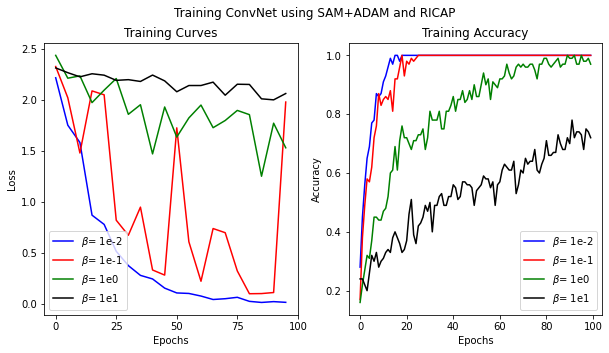

In [ ]:
colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(10,5))
for t in range(4):
  plt.suptitle(r"Training ConvNet using SAM+ADAM and RICAP")
  plt.subplot(1,2,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.xticks([0,5,10,15,20],[0,25,50,75,100])
  plt.title("Training Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend([r"$\beta$= 1e-2",r"$\beta$= 1e-1",r"$\beta$= 1e0",r"$\beta$= 1e1"])
  plt.subplot(1,2,2)
  plt.plot(train_accuracies[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend([r"$\beta$= 1e-2",r"$\beta$= 1e-1",r"$\beta$= 1e0",r"$\beta$= 1e1"])
  

### Experiment 2: The effect of changing the augmentation technique on the convergence of ConvNet while using SAM+Adam at a lr=1e-3 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


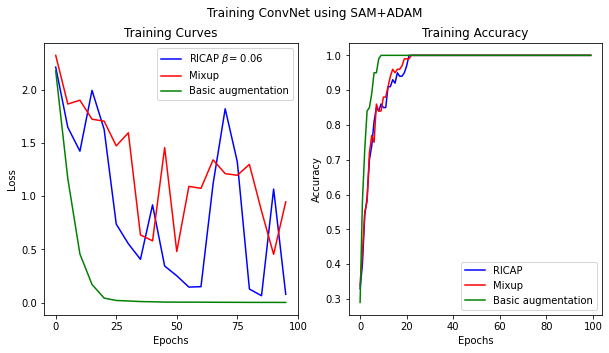

In [ ]:
colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(10,5))
for t in range(3):
  plt.suptitle(r"Training ConvNet using SAM+ADAM")
  plt.subplot(1,2,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.xticks([0,5,10,15,20],[0,25,50,75,100])
  plt.title("Training Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend([r"RICAP $\beta$= 0.06","Mixup","Basic augmentation"])
  plt.subplot(1,2,2)
  plt.plot(train_accuracies[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["RICAP","Mixup","Basic augmentation"])

### Experiment 3: The effect of changing the optimzer on the convergence of training for ConvNet at a lr=1e-3

There is just a mistake in the title it should be just "Training ConvNet" 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


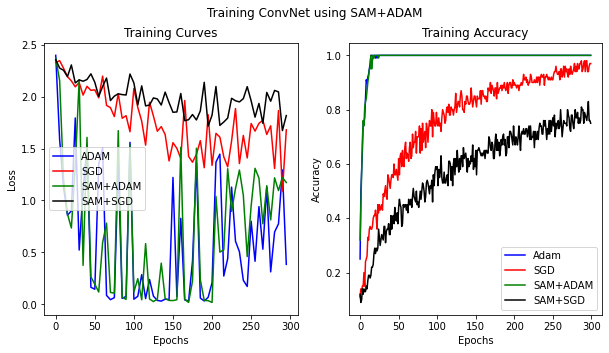

In [ ]:
colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(10,5))
for t in range(4):
  plt.suptitle(r"Training ConvNet using SAM+ADAM")
  plt.subplot(1,2,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.xticks([0,10,20,30,40,50,60],[0,50,20*5,30*5,40*5,50*5,60*5])
  plt.title("Training Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(["ADAM","SGD","SAM+ADAM", "SAM+SGD"])
  plt.subplot(1,2,2)
  plt.plot(train_accuracies[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(["Adam","SGD","SAM+ADAM", "SAM+SGD"])
  

### Experiment 4: The effect of changing the learning rate on the convergence of ConvNet while using SAM+Adam

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


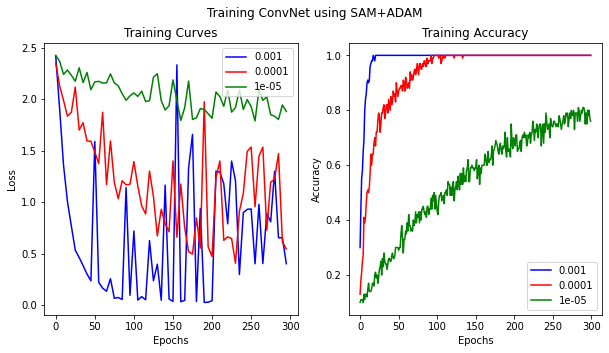

In [ ]:
colors = ["blue","red","green","black","magenta"]
plt.figure(figsize=(10,5))
for t in range(len(lrs)):
  plt.suptitle(r"Training ConvNet using SAM+ADAM")
  plt.subplot(1,2,1)
  plt.plot(train_losses[t],color= colors[t])
  plt.xticks([0,10,20,30,40,50,60],[0,50,20*5,30*5,40*5,50*5,60*5])
  plt.title("Training Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend(lrs)
  plt.subplot(1,2,2)
  plt.plot(train_accuracies[t],color= colors[t])
  plt.title("Training Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(lrs)